<a href="https://colab.research.google.com/github/seunghoona/study-ai-mnist/blob/main/1_3_MNIST_deep_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import SGD
from torch.optim import Adam

In [48]:
# 정확도 측정 함수
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()  # 평가 모드
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    return acc / cnt

# Plot 함수
def plot_acc(train_accs, test_accs, title="default plot", label1='train', label2='test'):
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.legend()
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

[MYCODE] dataset 리팩토링

- dataset 중복코드 제거
- trainset 생성
- testset 생성

In [3]:
transform = transforms.ToTensor()

def get_dataset(train= True, download=True):
    return torchvision.datasets.CIFAR10(
    root='./data',
    train=train,
    download=download,
    transform=transform
)

batch_size = 256
def get_loader(dataset, suffle=True):
    return torch.utils.data.DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=suffle
)


trainset = get_dataset()
testset = get_dataset(False)

print(f"trainset size: {len(trainset)}")
print(f"testset size: {len(testset)}")

trainloader = get_loader(trainset)
testloader = get_loader(testset, False)

print(f"trainloader size: {len(trainloader)}")
print(f"testloader size: {len(testloader)}")


100%|██████████| 170M/170M [00:02<00:00, 67.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
trainset size: 50000
testset size: 10000
trainloader size: 196
testloader size: 40


In [4]:
data_iter = iter(trainloader)
images, labels = next(data_iter)
batch_size, channels, height, width = images.shape

# 이미지 크기와 채널 수 확인
print(f"Image shape: {images.shape}")  # 출력 예: (256, 3, 32, 32)
print(f"Batch size: {batch_size}")
print(f"Number of channels: {channels}")
print(f"Height: {height}")
print(f"Width: {width}")

Image shape: torch.Size([256, 3, 32, 32])
Batch size: 256
Number of channels: 3
Height: 32
Width: 32


In [18]:
class Model(nn.Module):
  def __init__(self, input_dim, n_dim, act):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = act()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    # 활성함수를 삭제
    return self.layer3(x)

class DropoutLeakyReLUMLP(nn.Module):
  def __init__(self, input_dim, n_dim, act):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = act()
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.dropout(self.act(self.layer1(x)))
    x = self.dropout(self.act(self.layer2(x)))
    # 활성함수를 삭제
    return self.layer3(x)


[MYCODE] LeakyReLU 변경

- 손실함수를 ReLU 에서 LeakyReLU 변경한다.

In [6]:
model_sgd = Model(width * height * channels, 1024, nn.LeakyReLU).to('cuda')

In [39]:
model_adm = Model(width * height * channels, 1024, nn.LeakyReLU).to('cuda')
model_sigmoid = Model(width * height * channels, 1024, nn.Sigmoid).to('cuda')
model_dropout = DropoutLeakyReLUMLP(width * height * channels, 1024, nn.LeakyReLU).to('cuda')

In [40]:
lr = 0.001
optimizer_sgd = SGD(model_sgd.parameters(), lr=lr)
optimizer_adam = Adam(model_adm.parameters(), lr=lr)
optimizer_sigmoid_adam = Adam(model_sigmoid.parameters(), lr=lr)
optimizer_LeakyLeRU_adam = Adam(model_dropout.parameters(), lr=lr)

In [41]:
cretaition = nn.CrossEntropyLoss()

[LOG] 모델학습 시작

- SGD 모델과 아담 모델을 각각학습하여 각각의 옵티마이저를 이용하여 학습시켰습니다.

In [43]:
n_epochs = 50

# Lists for Accuracy Tracking
train_sgd_accuracies = []
train_adm_accuracies = []
train_sigmoid_accuracies = []
train_leakyLeRU_accuracies = []
test_leakyLeRU_accuracies = []

for epoch in range(n_epochs):
  total_sgd_loss = 0.
  total_adam_loss = 0.
  total_sigmoid_adam_loss = 0.
  total_leakyLeRU_adam_loss = 0.
  model_dropout.train()  # Dropout 활성화

  for data in trainloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    # LeakyReLU + SGD
    model_sgd.zero_grad()
    preds = model_sgd(inputs)
    loss = cretaition(preds, labels)
    loss.backward()
    optimizer_sgd.step()
    total_sgd_loss += loss.item()

    # LeakyReLU + ADAM
    model_adm.zero_grad()
    preds = model_adm(inputs)
    loss = cretaition(preds, labels)
    loss.backward()
    optimizer_adam.step()
    total_adam_loss += loss.item()

    # sigmoid model + ADAM
    model_sigmoid.zero_grad()
    preds = model_sigmoid(inputs)
    loss = cretaition(preds, labels)
    loss.backward()
    optimizer_sigmoid_adam.step()
    total_sigmoid_adam_loss += loss.item()

    # LeakyReLU + dropout + ADAM
    model_dropout.zero_grad()
    preds = model_dropout(inputs)
    loss = cretaition(preds, labels)
    loss.backward()
    optimizer_LeakyLeRU_adam.step()
    total_leakyLeRU_adam_loss += loss.item()

  # Epoch 종료 후 정확도 계산
  train_sgd_accuracy = accuracy(model_sgd, trainloader)
  train_adm_accuracy = accuracy(model_adm, trainloader)
  train_sigmoid_accuracy = accuracy(model_sigmoid, trainloader)
  train_leakyLeRU_accuracy = accuracy(model_sigmoid, trainloader)
  test_leakyLeRU_accuraccy = accuracy(model_dropout, testloader)

  train_sgd_accuracies.append(train_sgd_accuracy)
  train_adm_accuracies.append(train_adm_accuracy)
  train_sigmoid_accuracies.append(train_sigmoid_accuracy)
  train_leakyLeRU_accuracies.append(train_leakyLeRU_accuracy)
  test_leakyLeRU_accuracies.append(test_leakyLeRU_accuraccy)

  print(f"Epoch SGD {epoch + 1}/{n_epochs}, Loss: {total_sgd_loss / len(trainloader):.4f}, Train Acc: {train_sgd_accuracy:.4f}")
  print(f"Epoch ADM {epoch + 1}/{n_epochs}, Loss: {total_adam_loss / len(trainloader):.4f}, Train Acc: {train_adm_accuracy:.4f}")
  print(f"Epoch SIGMOID + ADM {epoch + 1}/{n_epochs}, Loss: {total_sigmoid_adam_loss / len(trainloader):.4f}, Train Acc: {train_sigmoid_accuracy:.4f}")
  print(f"Epoch leakyLeRU + DROPOUT + ADM {epoch + 1}/{n_epochs}, Loss: {total_leakyLeRU_adam_loss / len(trainloader):.4f}, Train Acc: {train_leakyLeRU_accuracy:.4f},  Test Acc: {test_leakyLeRU_accuraccy:.4f}")

# 모델 저장 경로
model_sgd_path = "model_sgd.pth"
model_adam_path = "model_adam.pth"

# SGD 모델 저장
torch.save(model_sgd.state_dict(), model_sgd_path)
print(f"SGD Model saved to {model_sgd_path}")

# Adam 모델 저장
torch.save(model_adm.state_dict(), model_adam_path)
print(f"Adam Model saved to {model_adam_path}")

Epoch SGD 1/50, Loss: 1.7645, Train Acc: 0.3800
Epoch ADM 1/50, Loss: 1.6673, Train Acc: 0.4331
Epoch SIGMOID + ADM 1/50, Loss: 1.7586, Train Acc: 0.3902
Epoch leakyLeRU + DROPOUT + ADM 1/50, Loss: 1.6839, Train Acc: 0.3902,  Test Acc: 0.4156
Epoch SGD 2/50, Loss: 1.7634, Train Acc: 0.3810
Epoch ADM 2/50, Loss: 1.5677, Train Acc: 0.4464
Epoch SIGMOID + ADM 2/50, Loss: 1.6543, Train Acc: 0.4105
Epoch leakyLeRU + DROPOUT + ADM 2/50, Loss: 1.6061, Train Acc: 0.4105,  Test Acc: 0.4055
Epoch SGD 3/50, Loss: 1.7609, Train Acc: 0.3808
Epoch ADM 3/50, Loss: 1.5038, Train Acc: 0.4685
Epoch SIGMOID + ADM 3/50, Loss: 1.5903, Train Acc: 0.4332
Epoch leakyLeRU + DROPOUT + ADM 3/50, Loss: 1.5491, Train Acc: 0.4332,  Test Acc: 0.4465
Epoch SGD 4/50, Loss: 1.7587, Train Acc: 0.3825
Epoch ADM 4/50, Loss: 1.4629, Train Acc: 0.4984
Epoch SIGMOID + ADM 4/50, Loss: 1.5474, Train Acc: 0.4671
Epoch leakyLeRU + DROPOUT + ADM 4/50, Loss: 1.5094, Train Acc: 0.4671,  Test Acc: 0.4743
Epoch SGD 5/50, Loss: 1.7572

[MYCODE] SGD 와  ADAM 학습된 각각의 에포츠 활성함수  대해 플로팅

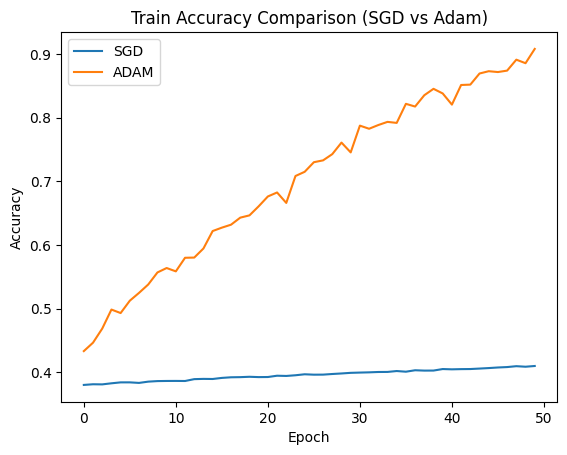

In [54]:
# 정확도 Plot
plot_acc(train_sgd_accuracies, train_adm_accuracies, "Train Accuracy Comparison (SGD vs Adam)", 'SGD', 'ADAM')

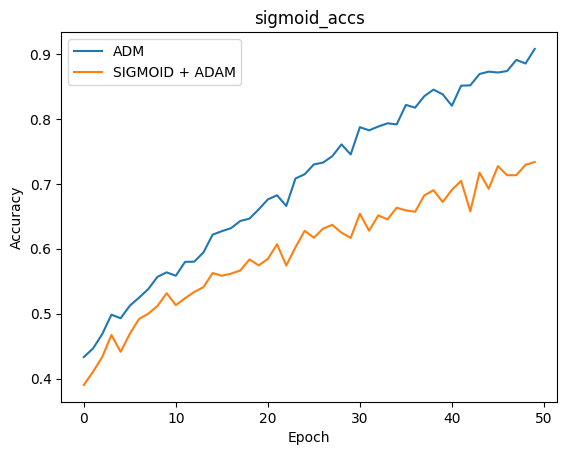

In [55]:
plot_acc(train_adm_accuracies, train_sigmoid_accuracies, "sigmoid_accs", 'ADM', 'SIGMOID + ADAM')

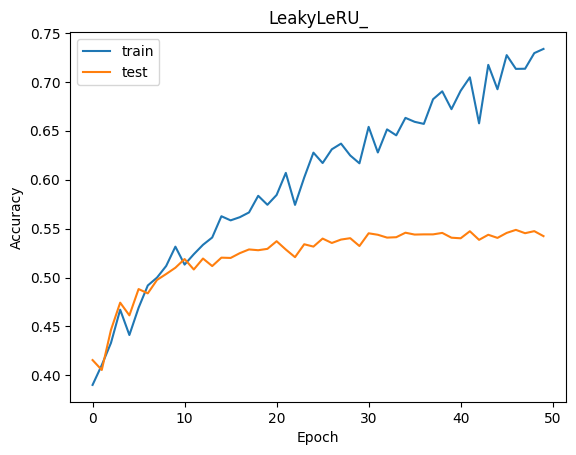

In [56]:
plot_acc(train_leakyLeRU_accuracies, test_leakyLeRU_accuracies, "LeakyLeRU_", 'train', 'test')